### Logistic Regression

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import (confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay)
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier.threshold import discrimination_threshold

import xgboost as xgb

import optuna
import flaml

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("training.csv")
test = pd.read_csv("testing.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Honorific
0,1,0,3,1,young adult,1,0,2.692582,0,S,mr
1,2,1,1,0,adult,1,0,8.442944,1,C,mrs
2,3,1,3,0,adult,0,0,2.815138,0,S,miss
3,4,1,1,0,adult,1,0,7.286975,1,S,mrs
4,5,0,3,1,adult,0,0,2.837252,0,S,mr


### Onehot Encoding

In [6]:
encoder_class = OneHotEncoder(sparse_output=False)
encoder_age = OneHotEncoder(sparse_output=False)
encoder_emb = OneHotEncoder(sparse_output=False)
encoder_hon = OneHotEncoder(sparse_output=False)

In [7]:
encoded_class = encoder_class.fit_transform(train[['Pclass']]).astype(int)
encoded_age = encoder_age.fit_transform(train[['Age']]).astype(int)
encoded_emb = encoder_emb.fit_transform(train[['Embarked']]).astype(int)
encoded_hon = encoder_hon.fit_transform(train[['Honorific']]).astype(int)

In [8]:
encoded_class_df = pd.DataFrame(
    encoded_class,
    columns=encoder_class.get_feature_names_out(['Pclass'])
)

encoded_age_df = pd.DataFrame(
    encoded_age,
    columns=encoder_age.get_feature_names_out(['Age'])
)

encoded_emb_df = pd.DataFrame(
    encoded_emb,
    columns=encoder_emb.get_feature_names_out(['Embarked'])
)

encoded_hon_df = pd.DataFrame(
    encoded_hon,
    columns=encoder_hon.get_feature_names_out(['Honorific'])
)

In [9]:
encoded_df = pd.concat([encoded_class_df, encoded_age_df, encoded_emb_df], axis=1) #

In [10]:
train = pd.concat([train, encoded_df], axis = 1)

In [11]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Pclass_2,Pclass_3,Age_adult,Age_child,Age_senior,Age_teen,Age_young adult,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,young adult,1,0,2.692582,0,S,...,0,1,0,0,0,0,1,0,0,1
1,2,1,1,0,adult,1,0,8.442944,1,C,...,0,0,1,0,0,0,0,1,0,0
2,3,1,3,0,adult,0,0,2.815138,0,S,...,0,1,1,0,0,0,0,0,0,1
3,4,1,1,0,adult,1,0,7.286975,1,S,...,0,0,1,0,0,0,0,0,0,1
4,5,0,3,1,adult,0,0,2.837252,0,S,...,0,1,1,0,0,0,0,0,0,1


In [12]:
encoded_class = encoder_class.fit_transform(test[['Pclass']]).astype(int)
encoded_age = encoder_age.fit_transform(test[['Age']]).astype(int)
encoded_emb = encoder_emb.fit_transform(test[['Embarked']]).astype(int)
encoded_hon = encoder_hon.fit_transform(test[['Honorific']]).astype(int)

In [13]:
encoded_class_df = pd.DataFrame(
    encoded_class,
    columns=encoder_class.get_feature_names_out(['Pclass'])
)

encoded_age_df = pd.DataFrame(
    encoded_age,
    columns=encoder_age.get_feature_names_out(['Age'])
)

encoded_emb_df = pd.DataFrame(
    encoded_emb,
    columns=encoder_emb.get_feature_names_out(['Embarked'])
)

encoded_hon_df = pd.DataFrame(
    encoded_hon,
    columns=encoder_hon.get_feature_names_out(['Honorific'])
)

In [14]:
encoded_df = pd.concat([encoded_class_df, encoded_age_df, encoded_emb_df, encoded_hon_df], axis=1)

In [15]:
test = pd.concat([test, encoded_df], axis = 1)

In [16]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Honorific,...,Pclass_2,Pclass_3,Age_adult,Age_child,Age_senior,Age_teen,Age_young adult,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,adult,0,0,2.798071,0,Q,mr,...,0,1,1,0,0,0,0,0,1,0
1,893,3,0,adult,1,0,2.645751,0,S,mrs,...,0,1,1,0,0,0,0,0,0,1
2,894,2,1,senior,0,0,3.112475,0,Q,mr,...,1,0,0,0,1,0,0,0,1,0
3,895,3,1,adult,0,0,2.943213,0,S,mr,...,0,1,1,0,0,0,0,0,0,1
4,896,3,0,young adult,1,1,3.505353,0,S,mrs,...,0,1,0,0,0,0,1,0,0,1


### Train-Test Datasets

Split the training data set into two, a new training set and a test set to validate the model, and then use the model to predict on the provided training set. 

In [18]:
X = train.drop(columns=['PassengerId', 'Pclass', 'Age', 'Honorific', 'Embarked', 'Survived'])
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
test_id = test['PassengerId']
test = test.drop(columns=['PassengerId', 'Pclass', 'Age', 'Honorific', 'Embarked'])

### Model

#### Optuna Hypertuned

In [21]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate multiple metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Use accuracy as the primary optimization metric
    return accuracy

In [22]:
def optimize_model(n_trials=100):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("\nStudy statistics:")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Best trial:")
    
    trial = study.best_trial
    print(f"  Accuracy: {trial.value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")
    
    # Create and fit best model
    best_model = xgb.XGBClassifier(**study.best_params)
    best_model.fit(X_train, y_train)
    
    # Evaluate final model
    y_pred = best_model.predict(X_test)
    
    print("\nFinal model performance:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    return best_model, study

In [23]:
best_model, study = optimize_model(n_trials=150)

[I 2024-12-21 17:57:48,902] A new study created in memory with name: no-name-032d5f64-6e45-4933-8c9b-9f68c40d8667
[I 2024-12-21 17:57:48,946] Trial 0 finished with value: 0.8134328358208955 and parameters: {'max_depth': 2, 'learning_rate': 0.15730273138026285, 'n_estimators': 259, 'min_child_weight': 3, 'subsample': 0.6449992810785309, 'colsample_bytree': 0.6401139747854769}. Best is trial 0 with value: 0.8134328358208955.
[I 2024-12-21 17:57:49,173] Trial 1 finished with value: 0.7947761194029851 and parameters: {'max_depth': 8, 'learning_rate': 0.0028746583222955683, 'n_estimators': 565, 'min_child_weight': 1, 'subsample': 0.8269780362471086, 'colsample_bytree': 0.8409709229300208}. Best is trial 0 with value: 0.8134328358208955.
[I 2024-12-21 17:57:49,201] Trial 2 finished with value: 0.8059701492537313 and parameters: {'max_depth': 4, 'learning_rate': 0.1628360432846475, 'n_estimators': 103, 'min_child_weight': 6, 'subsample': 0.8381354079573557, 'colsample_bytree': 0.7739596236597


Study statistics:
  Number of finished trials: 150
  Best trial:
  Accuracy: 0.8433

Best hyperparameters:
  max_depth: 2
  learning_rate: 0.21020825047401948
  n_estimators: 329
  min_child_weight: 2
  subsample: 0.9309091581909741
  colsample_bytree: 0.7040765590288189

Final model performance:
  Accuracy: 0.8433


In [24]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7040765590288189, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21020825047401948,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=329, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
y_pred = best_model.predict(X_test)

In [26]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       157
           1       0.83      0.78      0.81       111

    accuracy                           0.84       268
   macro avg       0.84      0.83      0.84       268
weighted avg       0.84      0.84      0.84       268



In [27]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'All Variables')

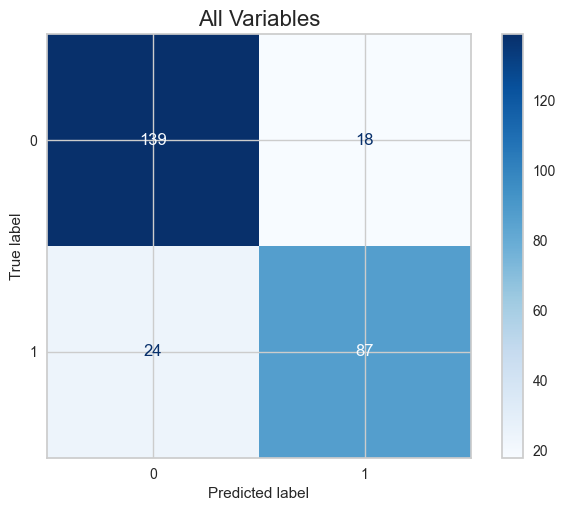

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)

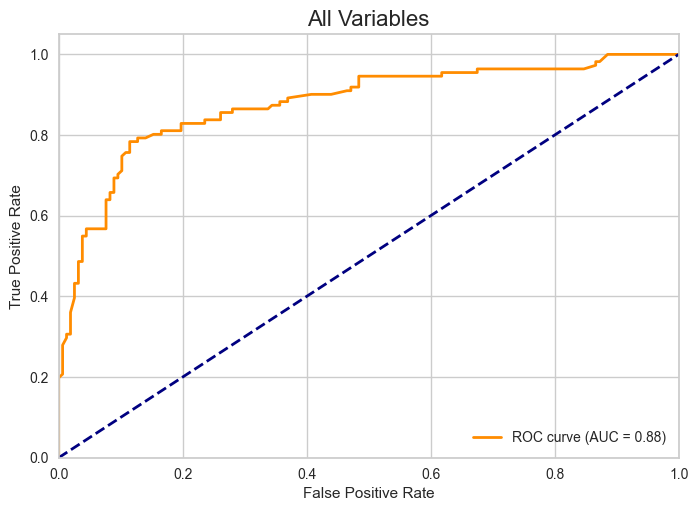

In [29]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")

Text(0.5, 1.0, 'All Variables')

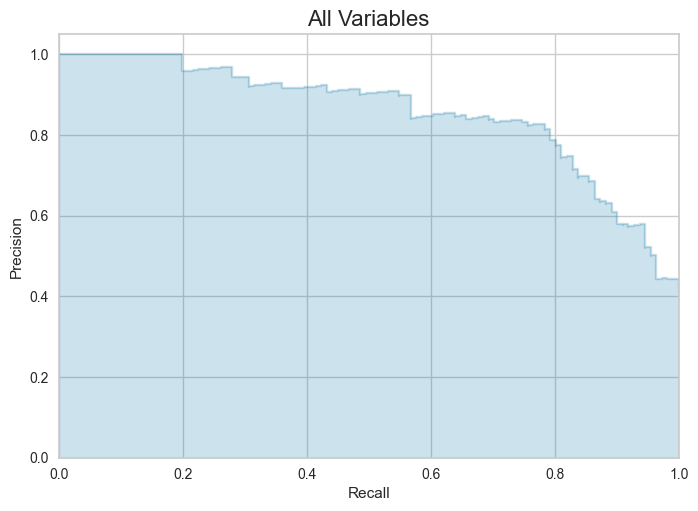

In [30]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)

In [31]:
y_valid = best_model.predict(test)

In [32]:
y_valid = pd.Series(y_valid, name='Survived')
submission = pd.concat([test_id, y_valid], axis=1)

In [33]:
submission.to_csv("xgboost_optuna.csv", index=False)